# HW 09: Variational Autoencoders

Description: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/homework9.html

In [0]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np

In [0]:
# changed configuration to this instead of argparse for easier interaction
CUDA = False
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 10
ZDIMS = 20
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

In [3]:
# Download or load downloaded MNIST dataset
# shuffle data at every epoch
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

0it [00:00, ?it/s]

9920512it [00:01, 8045439.07it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136079.25it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2242969.47it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51080.47it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
# Same for test data
test_data=datasets.MNIST('data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)


In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
        self.fc3 = nn.Linear(ZDIMS, 400)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):

        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:

        if self.training:

            std = logvar.mul(0.5).exp_()  # type: Variable

            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)

        else:

            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
#torch.set_default_tensor_type('torch.FloatTensor')
model = VAE()

In [0]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [0]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [0]:
def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                      str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))




In [10]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, ZDIMS))
    print(sample.shape)
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
                str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.005490
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.002996
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.002372
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.002134
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.002183
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.002076
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.002032
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.001998
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001857
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001822
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001812
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001661
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001735
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.001673
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.001662
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001563
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.001587
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.001606
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.001550
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001592
Train Epoch: 1 [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


====> Test set loss: 0.0012
torch.Size([64, 20])
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001248
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.001271
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.001209
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.001284
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.001262
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.001218
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.001229
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.001272
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.001271
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.001244
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.001252
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.001226
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.001208
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.001208
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.001221
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.001275
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.001201
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.001210
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.001207
Train Epoch: 2 [2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


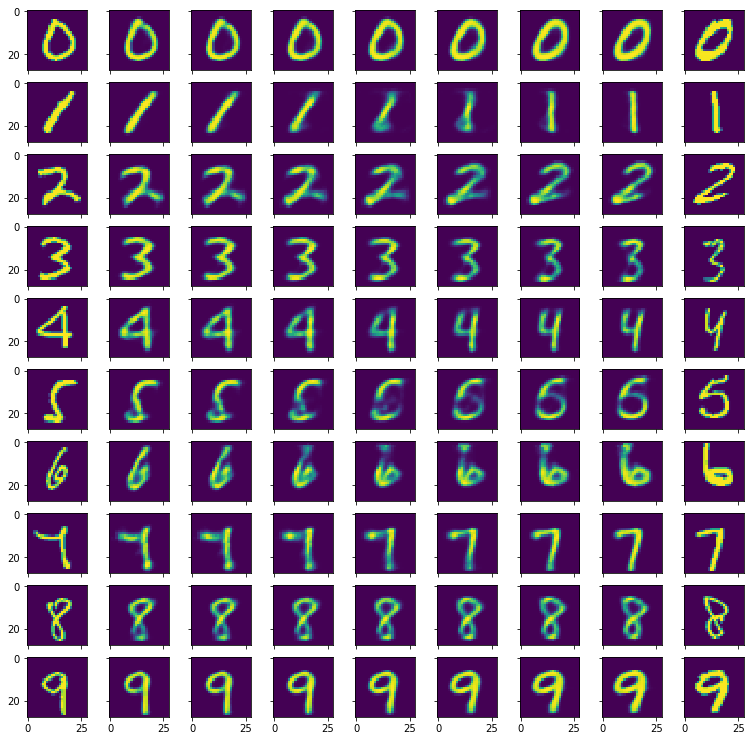

In [11]:
import matplotlib.pyplot as plt
import numpy as np
labels=np.arange(10)
fig, axes = plt.subplots(nrows=10, ncols=9, sharex=True, sharey=True,figsize=(13,13))

for label in labels:
  idx = test_data.targets==label
  idx=(idx != 0).nonzero().view(-1)
  loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(idx),**kwargs)
  data,_=next(iter(loader))
  image_1=data[0].reshape((28,28))
  image_2=data[1].reshape((28,28))
  axes[label,0].imshow(image_1)
  axes[label,8].imshow(image_2)
  data=Variable(data)
  _,mu, logvar=model.forward(data)
  mu=mu.detach().numpy()
  var=logvar.detach().numpy()
  inter_num=7
  interpolation_mu=np.zeros((inter_num,20))
  interpolation_var=np.zeros((inter_num,20))
  for i in range(20):
      mu_spaced=np.linspace(mu[0,i],mu[1,i],num=inter_num,endpoint=False)
      var_spaced=np.linspace(var[0,i],var[1,i],num=inter_num,endpoint=False)
      interpolation_mu[:,i]=mu_spaced
      interpolation_var[:,i]=var_spaced
  interpolation_var=Variable(torch.tensor(interpolation_var))
  interpolation_mu=Variable(torch.tensor(interpolation_mu))
  z = model.reparameterize(interpolation_mu, interpolation_var)
  z=Variable(torch.tensor(z).float())
  sample=model.decode(z).cpu()
  sample=sample.detach().numpy()
  for i in range(inter_num):
    image=sample[i].reshape((28,28))
    axes[label,i+1].imshow(image)
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


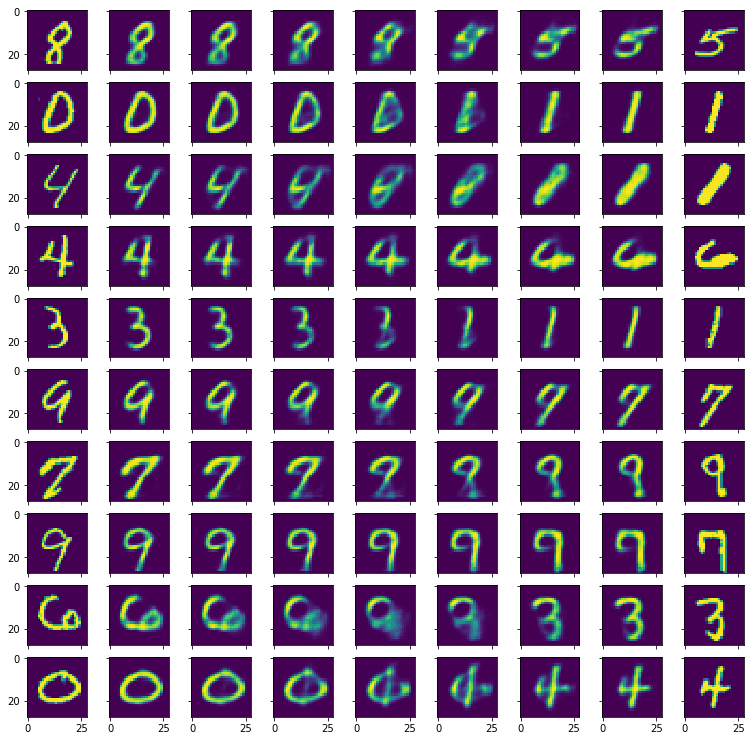

In [12]:
fig, axes = plt.subplots(nrows=10, ncols=9, sharex=True, sharey=True,figsize=(13,13))
k=0
while k<10:
  loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=True,**kwargs)
  data,labels=next(iter(loader))
  if labels[0]==labels[1]:
    continue
  image_1=data[0].reshape((28,28))
  image_2=data[1].reshape((28,28))
  axes[k,0].imshow(image_1)
  axes[k,8].imshow(image_2)
  data=Variable(data)
  _,mu, logvar=model.forward(data)
  mu=mu.detach().numpy()
  var=logvar.detach().numpy()
  inter_num=7
  interpolation_mu=np.zeros((inter_num,20))
  interpolation_var=np.zeros((inter_num,20))
  for i in range(20):
      mu_spaced=np.linspace(mu[0,i],mu[1,i],num=inter_num,endpoint=False)
      var_spaced=np.linspace(var[0,i],var[1,i],num=inter_num,endpoint=False)
      interpolation_mu[:,i]=mu_spaced
      interpolation_var[:,i]=var_spaced
  interpolation_var=Variable(torch.tensor(interpolation_var))
  interpolation_mu=Variable(torch.tensor(interpolation_mu))
  z = model.reparameterize(interpolation_mu, interpolation_var)
  z=Variable(torch.tensor(z).float())
  sample=model.decode(z).cpu()
  sample=sample.detach().numpy()
  for j in range(inter_num):
    image=sample[j].reshape((28,28))
    axes[k,j+1].imshow(image)
  k+=1
plt.show()
